Premani

In [4]:
import os
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

#############################################
# Loss Functions and Metrics
#############################################

In [6]:

def dice_loss(pred, target, smooth=1):
    """
    Soft Dice Loss.
    pred: logits from the model of shape [B, C, H, W]
    target: ground truth tensor [B, C, H, W] (binary, 0 or 1)
    """
    pred = torch.sigmoid(pred)  # convert logits to probabilities
    # Flatten the tensors per channel
    pred_flat = pred.view(pred.size(0), pred.size(1), -1)
    target_flat = target.view(target.size(0), target.size(1), -1)
    
    intersection = (pred_flat * target_flat).sum(-1)
    union = pred_flat.sum(-1) + target_flat.sum(-1)
    
    dice = (2 * intersection + smooth) / (union + smooth)
    # We want to minimize loss, so subtract dice coefficient from 1
    loss = 1 - dice
    return loss.mean()

def focal_loss_with_logits(inputs, targets, alpha=0.6, gamma=2, reduction='mean'):
    """
    Focal Loss for binary classification with logits.
    inputs: logits from the model, shape [B, C, H, W]
    targets: ground truth tensor, same shape as inputs.
    """
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    pt = torch.exp(-BCE_loss)  # prevents nans when probability 0
    focal_loss = alpha * (1-pt)**gamma * BCE_loss
    if reduction == 'mean':
        return focal_loss.mean()
    elif reduction == 'sum':
        return focal_loss.sum()
    else:
        return focal_loss

def combined_loss(pred, target, focal_weight=0.5, dice_weight=0.5):
    """
    Combination of Focal Loss and Dice Loss.
    Adjust focal_weight and dice_weight to balance their contributions.
    """
    f_loss = focal_loss_with_logits(pred, target, alpha=0.13, gamma=2, reduction='mean')
    d_loss = dice_loss(pred, target)
    return focal_weight * f_loss + dice_weight * d_loss

def dice_coef_metric(pred, target, smooth=1):
    """
    Computes Dice Coefficient for evaluation.
    """
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    pred_flat = pred.view(pred.size(0), pred.size(1), -1)
    target_flat = target.view(target.size(0), target.size(1), -1)
    intersection = (pred_flat * target_flat).sum(-1)
    union = pred_flat.sum(-1) + target_flat.sum(-1)
    dice = (2 * intersection + smooth) / (union + smooth)
    return dice.mean().item()

def iou_score_metric(pred, target, smooth=1):
    """
    Computes Intersection over Union (IoU) score.
    """
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    pred_flat = pred.view(pred.size(0), pred.size(1), -1)
    target_flat = target.view(target.size(0), target.size(1), -1)
    intersection = (pred_flat * target_flat).sum(-1)
    union = (pred_flat + target_flat - pred_flat * target_flat).sum(-1)
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean().item()

def pixel_accuracy_metric(pred, target):
    """
    Computes pixel accuracy over all channels.
    """
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    correct = (pred == target).float().sum()
    total = torch.numel(target)
    return (correct / total).item()

#############################################
# Improved Residual U-Net Architecture
#############################################

In [7]:
class ResidualDoubleConv(nn.Module):
    """
    Residual block: Conv => BN => ReLU => Dropout => Conv => BN, then add skip connection.
    """
    def __init__(self, in_channels, out_channels, drop_prob=0.1):
        super(ResidualDoubleConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(p=drop_prob)
        # Projection if in_channels != out_channels
        self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None

    def forward(self, x):
        identity = x if self.residual_conv is None else self.residual_conv(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

def init_weights(module):
    """
    Apply Kaiming initialization for convolutional layers.
    """
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)

class UNetImproved(nn.Module):
    """
    Improved U-Net using ResidualDoubleConv blocks.
    """
    def __init__(self, in_channels=3, out_channels=5, drop_prob=0.1):
        super(UNetImproved, self).__init__()
        # Encoder
        self.enc1 = ResidualDoubleConv(in_channels, 64, drop_prob)
        self.enc2 = ResidualDoubleConv(64, 128, drop_prob)
        self.enc3 = ResidualDoubleConv(128, 256, drop_prob)
        self.enc4 = ResidualDoubleConv(256, 512, drop_prob)
        self.pool = nn.MaxPool2d(2)
        # Bottleneck
        self.bottleneck = ResidualDoubleConv(512, 1024, drop_prob)
        # Decoder
        self.up4  = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = ResidualDoubleConv(1024, 512, drop_prob)
        self.up3  = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = ResidualDoubleConv(512, 256, drop_prob)
        self.up2  = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = ResidualDoubleConv(256, 128, drop_prob)
        self.up1  = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = ResidualDoubleConv(128, 64, drop_prob)
        # Output layer
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)
        self.apply(init_weights)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b = self.bottleneck(self.pool(e4))
        d4 = self.up4(b)
        d4 = torch.cat((e4, d4), dim=1)
        d4 = self.dec4(d4)
        d3 = self.up3(d4)
        d3 = torch.cat((e3, d3), dim=1)
        d3 = self.dec3(d3)
        d2 = self.up2(d3)
        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.dec1(d1)
        out = self.out(d1)
        return out


#############################################
# Dataset Preparation
#############################################

In [8]:
# Mapping for 5 segmentation classes
mask_map = {'MA': 0, 'HE': 1, 'EX': 2, 'SE': 3, 'OD': 4}

# Paths for images and masks (adjust paths if needed)
IMAGE_DIR = '/kaggle/input/dataset234/A. Segmentation/1. Original Images/b. Testing Set'
MASK_DIRS = {
    'MA': '/kaggle/input/dataset234/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/1. Microaneurysms',
    'HE': '/kaggle/input/dataset234/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/2. Haemorrhages',
    'EX': '/kaggle/input/dataset234/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/3. Hard Exudates',
    'SE': '/kaggle/input/dataset234/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/4. Soft Exudates',
    'OD': '/kaggle/input/dataset234/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/5. Optic Disc'
}
OUTPUT_IMAGE_DIR = '/kaggle/working/Final_images'
OUTPUT_MASK_DIR = '/kaggle/working/Final_masks'
os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
os.makedirs(OUTPUT_MASK_DIR, exist_ok=True)

def compile_masks():
    """
    Generate processed images and multi-channel masks.
    """
    for filename in tqdm(os.listdir(IMAGE_DIR), desc="Compiling masks"):
        if filename.endswith('.jpg'):
            base_name = os.path.splitext(filename)[0]
            img_path = os.path.join(IMAGE_DIR, filename)
            image = cv2.imread(img_path)
            if image is None:
                continue
            image = cv2.resize(image, (512, 512))
            cv2.imwrite(os.path.join(OUTPUT_IMAGE_DIR, filename), image)
            
            mask = np.zeros((512, 512, 5), dtype=np.uint8)
            for class_name, dir_path in MASK_DIRS.items():
                mask_file = os.path.join(dir_path, f"{base_name}_{class_name}.tif")
                if os.path.exists(mask_file):
                    m = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
                    if m is None:
                        continue
                    m = cv2.resize(m, (512, 512))
                    m = (m > 20).astype(np.uint8)
                    mask[:, :, mask_map[class_name]] = m
            np.save(os.path.join(OUTPUT_MASK_DIR, base_name + '.npy'), mask)

# Uncomment the following line if you need to generate masks
compile_masks()

class IDRiDDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_size=(512, 512), transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_size = img_size
        self.transform = transform
        self.images = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        base_name = os.path.splitext(img_name)[0]
        img_path = os.path.join(self.image_dir, img_name)
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Failed to load image: {img_path}")
        image = cv2.resize(image, self.img_size)
        # Apply CLAHE on L channel for enhanced contrast
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        l = self.clahe.apply(l)
        lab = cv2.merge((l, a, b))
        image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
        image = image / 255.0  # normalize
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        
        mask_path = os.path.join(self.mask_dir, base_name + '.npy')
        if not os.path.exists(mask_path):
            raise FileNotFoundError(f"Mask file not found: {mask_path}")
        mask = np.load(mask_path, allow_pickle=False)
        if mask.shape != (self.img_size[0], self.img_size[1], 5):
            raise ValueError(f"Unexpected mask shape: {mask.shape}")
        mask = (mask > 0).astype(np.uint8)
        mask = torch.tensor(mask, dtype=torch.float32).permute(2, 0, 1)
        return image, mask

Compiling masks: 100%|██████████| 27/27 [00:07<00:00,  3.53it/s]



#############################################
# Training and Evaluation Setup
#############################################

In [9]:
def train_model(model, dataloader, optimizer, device, num_epochs=10):
    model.train()
    epoch_losses = []
    epoch_dice = []
    epoch_iou = []
    epoch_acc = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_batches = 0
        for images, masks in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            masks = masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = combined_loss(outputs, masks)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            running_batches += images.size(0)
        avg_loss = running_loss / running_batches
        epoch_losses.append(avg_loss)
        # Evaluate metrics on a single batch from training (for monitoring)
        model.eval()
        with torch.no_grad():
            images, masks = next(iter(dataloader))
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            dice = dice_coef_metric(outputs, masks)
            iou = iou_score_metric(outputs, masks)
            acc = pixel_accuracy_metric(outputs, masks)
        model.train()
        epoch_dice.append(dice)
        epoch_iou.append(iou)
        epoch_acc.append(acc)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} | Dice: {dice:.4f} | IoU: {iou:.4f} | Acc: {acc:.4f}")
    return epoch_losses, epoch_dice, epoch_iou, epoch_acc

def evaluate_model(model, dataloader, device):
    model.eval()
    total_dice = 0.0
    total_iou = 0.0
    total_acc = 0.0
    count = 0
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            total_dice += dice_coef_metric(outputs, masks)
            total_iou += iou_score_metric(outputs, masks)
            total_acc += pixel_accuracy_metric(outputs, masks)
            count += 1
    return total_dice/count, total_iou/count, total_acc/count

def plot_training_curves(epochs, loss, dice, iou, acc):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.plot(epochs, loss, 'o-', label="Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()
    
    plt.subplot(1,3,2)
    plt.plot(epochs, dice, 'o-', label="Dice Coef")
    plt.xlabel("Epoch")
    plt.ylabel("Dice Coefficient")
    plt.title("Dice Coefficient")
    plt.legend()
    
    plt.subplot(1,3,3)
    plt.plot(epochs, iou, 'o-', label="IoU")
    plt.xlabel("Epoch")
    plt.ylabel("IoU")
    plt.title("Intersection over Union")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(4,4))
    plt.plot(epochs, acc, 'o-', label="Pixel Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Pixel Accuracy")
    plt.legend()
    plt.show()

def visualize_predictions(model, dataloader, device, num_channels=5):
    model.eval()
    with torch.no_grad():
        images, masks = next(iter(dataloader))
        images = images.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float().cpu().numpy()
        images = images.cpu().numpy()
        masks = masks.cpu().numpy()
    
    # Visualize for the first image in the batch
    idx = 0
    image = np.transpose(images[idx], (1, 2, 0))
    gt_mask = masks[idx]  # shape [5, H, W]
    pred_mask = preds[idx]
    
    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis("off")
    plt.show()
    
    # Plot each channel for ground truth and prediction
    fig, axs = plt.subplots(2, num_channels, figsize=(15,6))
    for ch in range(num_channels):
        axs[0, ch].imshow(gt_mask[ch], cmap='gray')
        axs[0, ch].set_title(f"GT Channel {ch}")
        axs[0, ch].axis("off")
        axs[1, ch].imshow(pred_mask[ch], cmap='gray')
        axs[1, ch].set_title(f"Pred Channel {ch}")
        axs[1, ch].axis("off")
    plt.tight_layout()
    plt.show()

#############################################
# Main Execution
#############################################

Starting training...


Epoch 1/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 1/120 - Loss: 0.5013 | Dice: 0.0212 | IoU: 0.0120 | Acc: 0.8471


Epoch 2/120: 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]


Epoch 2/120 - Loss: 0.4919 | Dice: 0.0671 | IoU: 0.0397 | Acc: 0.9548


Epoch 3/120: 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]


Epoch 3/120 - Loss: 0.4812 | Dice: 0.1015 | IoU: 0.0700 | Acc: 0.9824


Epoch 4/120: 100%|██████████| 7/7 [00:07<00:00,  1.08s/it]


Epoch 4/120 - Loss: 0.4485 | Dice: 0.1108 | IoU: 0.0780 | Acc: 0.9795


Epoch 5/120: 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]


Epoch 5/120 - Loss: 0.4270 | Dice: 0.1721 | IoU: 0.1465 | Acc: 0.9925


Epoch 6/120: 100%|██████████| 7/7 [00:07<00:00,  1.10s/it]


Epoch 6/120 - Loss: 0.4167 | Dice: 0.1467 | IoU: 0.1139 | Acc: 0.9911


Epoch 7/120: 100%|██████████| 7/7 [00:07<00:00,  1.12s/it]


Epoch 7/120 - Loss: 0.4092 | Dice: 0.2220 | IoU: 0.1796 | Acc: 0.9875


Epoch 8/120: 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


Epoch 8/120 - Loss: 0.4054 | Dice: 0.2188 | IoU: 0.1728 | Acc: 0.9867


Epoch 9/120: 100%|██████████| 7/7 [00:08<00:00,  1.14s/it]


Epoch 9/120 - Loss: 0.4036 | Dice: 0.2162 | IoU: 0.1797 | Acc: 0.9863


Epoch 10/120: 100%|██████████| 7/7 [00:08<00:00,  1.15s/it]


Epoch 10/120 - Loss: 0.4018 | Dice: 0.1982 | IoU: 0.1680 | Acc: 0.9889


Epoch 11/120: 100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


Epoch 11/120 - Loss: 0.3966 | Dice: 0.2338 | IoU: 0.2023 | Acc: 0.9823


Epoch 12/120: 100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


Epoch 12/120 - Loss: 0.3944 | Dice: 0.2543 | IoU: 0.2077 | Acc: 0.9892


Epoch 13/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 13/120 - Loss: 0.3912 | Dice: 0.2213 | IoU: 0.1852 | Acc: 0.9931


Epoch 14/120: 100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


Epoch 14/120 - Loss: 0.3852 | Dice: 0.2731 | IoU: 0.2318 | Acc: 0.9918


Epoch 15/120: 100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


Epoch 15/120 - Loss: 0.3776 | Dice: 0.2639 | IoU: 0.2233 | Acc: 0.9937


Epoch 16/120: 100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch 16/120 - Loss: 0.3741 | Dice: 0.2629 | IoU: 0.2239 | Acc: 0.9905


Epoch 17/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 17/120 - Loss: 0.3699 | Dice: 0.2538 | IoU: 0.2195 | Acc: 0.9938


Epoch 18/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 18/120 - Loss: 0.3657 | Dice: 0.2838 | IoU: 0.2367 | Acc: 0.9876


Epoch 19/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 19/120 - Loss: 0.3639 | Dice: 0.2489 | IoU: 0.2084 | Acc: 0.9900


Epoch 20/120: 100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


Epoch 20/120 - Loss: 0.3592 | Dice: 0.2954 | IoU: 0.2431 | Acc: 0.9933


Epoch 21/120: 100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


Epoch 21/120 - Loss: 0.3585 | Dice: 0.3346 | IoU: 0.2708 | Acc: 0.9913


Epoch 22/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 22/120 - Loss: 0.3522 | Dice: 0.3233 | IoU: 0.2646 | Acc: 0.9896


Epoch 23/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 23/120 - Loss: 0.3498 | Dice: 0.3077 | IoU: 0.2536 | Acc: 0.9955


Epoch 24/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 24/120 - Loss: 0.3463 | Dice: 0.3626 | IoU: 0.2925 | Acc: 0.9889


Epoch 25/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 25/120 - Loss: 0.3462 | Dice: 0.3146 | IoU: 0.2621 | Acc: 0.9882


Epoch 26/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 26/120 - Loss: 0.3496 | Dice: 0.3481 | IoU: 0.2795 | Acc: 0.9914


Epoch 27/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 27/120 - Loss: 0.3429 | Dice: 0.3189 | IoU: 0.2574 | Acc: 0.9866


Epoch 28/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 28/120 - Loss: 0.3360 | Dice: 0.3240 | IoU: 0.2649 | Acc: 0.9952


Epoch 29/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 29/120 - Loss: 0.3305 | Dice: 0.3150 | IoU: 0.2632 | Acc: 0.9936


Epoch 30/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 30/120 - Loss: 0.3373 | Dice: 0.3211 | IoU: 0.2632 | Acc: 0.9918


Epoch 31/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 31/120 - Loss: 0.3271 | Dice: 0.3625 | IoU: 0.2951 | Acc: 0.9960


Epoch 32/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 32/120 - Loss: 0.3281 | Dice: 0.3681 | IoU: 0.3084 | Acc: 0.9950


Epoch 33/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 33/120 - Loss: 0.3199 | Dice: 0.3527 | IoU: 0.2993 | Acc: 0.9934


Epoch 34/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 34/120 - Loss: 0.3236 | Dice: 0.2955 | IoU: 0.2415 | Acc: 0.9960


Epoch 35/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 35/120 - Loss: 0.3223 | Dice: 0.3426 | IoU: 0.2821 | Acc: 0.9898


Epoch 36/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 36/120 - Loss: 0.3144 | Dice: 0.3819 | IoU: 0.3238 | Acc: 0.9964


Epoch 37/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 37/120 - Loss: 0.3196 | Dice: 0.3455 | IoU: 0.2852 | Acc: 0.9898


Epoch 38/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 38/120 - Loss: 0.3203 | Dice: 0.3921 | IoU: 0.3254 | Acc: 0.9944


Epoch 39/120: 100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch 39/120 - Loss: 0.3135 | Dice: 0.3941 | IoU: 0.3218 | Acc: 0.9951


Epoch 40/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 40/120 - Loss: 0.3091 | Dice: 0.4531 | IoU: 0.3802 | Acc: 0.9920


Epoch 41/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 41/120 - Loss: 0.2991 | Dice: 0.3935 | IoU: 0.3528 | Acc: 0.9871


Epoch 42/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 42/120 - Loss: 0.2984 | Dice: 0.4629 | IoU: 0.4250 | Acc: 0.9623


Epoch 43/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 43/120 - Loss: 0.3031 | Dice: 0.4963 | IoU: 0.4419 | Acc: 0.9952


Epoch 44/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 44/120 - Loss: 0.2944 | Dice: 0.4701 | IoU: 0.4225 | Acc: 0.9942


Epoch 45/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 45/120 - Loss: 0.2860 | Dice: 0.4941 | IoU: 0.4318 | Acc: 0.9940


Epoch 46/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 46/120 - Loss: 0.2847 | Dice: 0.3979 | IoU: 0.3415 | Acc: 0.9957


Epoch 47/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 47/120 - Loss: 0.2750 | Dice: 0.4790 | IoU: 0.4139 | Acc: 0.9947


Epoch 48/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 48/120 - Loss: 0.2769 | Dice: 0.4917 | IoU: 0.4393 | Acc: 0.9956


Epoch 49/120: 100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


Epoch 49/120 - Loss: 0.2786 | Dice: 0.3694 | IoU: 0.3110 | Acc: 0.9923


Epoch 50/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 50/120 - Loss: 0.2726 | Dice: 0.5366 | IoU: 0.4805 | Acc: 0.9947


Epoch 51/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 51/120 - Loss: 0.2714 | Dice: 0.4722 | IoU: 0.4248 | Acc: 0.9976


Epoch 52/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 52/120 - Loss: 0.2725 | Dice: 0.5111 | IoU: 0.4497 | Acc: 0.9977


Epoch 53/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 53/120 - Loss: 0.2762 | Dice: 0.4233 | IoU: 0.3665 | Acc: 0.9979


Epoch 54/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 54/120 - Loss: 0.2635 | Dice: 0.4633 | IoU: 0.3887 | Acc: 0.9966


Epoch 55/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 55/120 - Loss: 0.2629 | Dice: 0.4204 | IoU: 0.3522 | Acc: 0.9908


Epoch 56/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 56/120 - Loss: 0.2642 | Dice: 0.5521 | IoU: 0.4847 | Acc: 0.9927


Epoch 57/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 57/120 - Loss: 0.2584 | Dice: 0.5570 | IoU: 0.4894 | Acc: 0.9976


Epoch 58/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 58/120 - Loss: 0.2592 | Dice: 0.4639 | IoU: 0.3995 | Acc: 0.9973


Epoch 59/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 59/120 - Loss: 0.2617 | Dice: 0.4770 | IoU: 0.4076 | Acc: 0.9964


Epoch 60/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 60/120 - Loss: 0.2566 | Dice: 0.4885 | IoU: 0.4096 | Acc: 0.9954


Epoch 61/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 61/120 - Loss: 0.2585 | Dice: 0.4847 | IoU: 0.4107 | Acc: 0.9955


Epoch 62/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 62/120 - Loss: 0.2531 | Dice: 0.4604 | IoU: 0.3855 | Acc: 0.9959


Epoch 63/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 63/120 - Loss: 0.2568 | Dice: 0.5277 | IoU: 0.4726 | Acc: 0.9977


Epoch 64/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 64/120 - Loss: 0.2562 | Dice: 0.5585 | IoU: 0.4855 | Acc: 0.9943


Epoch 65/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 65/120 - Loss: 0.2562 | Dice: 0.5586 | IoU: 0.4947 | Acc: 0.9943


Epoch 66/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 66/120 - Loss: 0.2562 | Dice: 0.5254 | IoU: 0.4560 | Acc: 0.9966


Epoch 67/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 67/120 - Loss: 0.2576 | Dice: 0.4084 | IoU: 0.3344 | Acc: 0.9912


Epoch 68/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 68/120 - Loss: 0.2554 | Dice: 0.5625 | IoU: 0.4925 | Acc: 0.9952


Epoch 69/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 69/120 - Loss: 0.2567 | Dice: 0.4918 | IoU: 0.4233 | Acc: 0.9967


Epoch 70/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 70/120 - Loss: 0.2490 | Dice: 0.4757 | IoU: 0.4130 | Acc: 0.9955


Epoch 71/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 71/120 - Loss: 0.2479 | Dice: 0.5626 | IoU: 0.4876 | Acc: 0.9953


Epoch 72/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 72/120 - Loss: 0.2433 | Dice: 0.6040 | IoU: 0.5345 | Acc: 0.9975


Epoch 73/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 73/120 - Loss: 0.2461 | Dice: 0.4672 | IoU: 0.3993 | Acc: 0.9975


Epoch 74/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 74/120 - Loss: 0.2429 | Dice: 0.4680 | IoU: 0.3989 | Acc: 0.9938


Epoch 75/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 75/120 - Loss: 0.2442 | Dice: 0.5378 | IoU: 0.4679 | Acc: 0.9962


Epoch 76/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 76/120 - Loss: 0.2437 | Dice: 0.5402 | IoU: 0.4668 | Acc: 0.9932


Epoch 77/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 77/120 - Loss: 0.2400 | Dice: 0.6080 | IoU: 0.5367 | Acc: 0.9969


Epoch 78/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 78/120 - Loss: 0.2417 | Dice: 0.5575 | IoU: 0.4913 | Acc: 0.9973


Epoch 79/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 79/120 - Loss: 0.2441 | Dice: 0.4903 | IoU: 0.4117 | Acc: 0.9917


Epoch 80/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 80/120 - Loss: 0.2397 | Dice: 0.5364 | IoU: 0.4617 | Acc: 0.9969


Epoch 81/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 81/120 - Loss: 0.2411 | Dice: 0.4973 | IoU: 0.4250 | Acc: 0.9932


Epoch 82/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 82/120 - Loss: 0.2364 | Dice: 0.5494 | IoU: 0.4794 | Acc: 0.9970


Epoch 83/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 83/120 - Loss: 0.2351 | Dice: 0.5250 | IoU: 0.4524 | Acc: 0.9981


Epoch 84/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 84/120 - Loss: 0.2383 | Dice: 0.5643 | IoU: 0.4928 | Acc: 0.9964


Epoch 85/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 85/120 - Loss: 0.2373 | Dice: 0.5138 | IoU: 0.4507 | Acc: 0.9975


Epoch 86/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 86/120 - Loss: 0.2362 | Dice: 0.4891 | IoU: 0.4147 | Acc: 0.9977


Epoch 87/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 87/120 - Loss: 0.2339 | Dice: 0.5473 | IoU: 0.4701 | Acc: 0.9964


Epoch 88/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 88/120 - Loss: 0.2343 | Dice: 0.5161 | IoU: 0.4517 | Acc: 0.9982


Epoch 89/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 89/120 - Loss: 0.2301 | Dice: 0.5060 | IoU: 0.4320 | Acc: 0.9981


Epoch 90/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 90/120 - Loss: 0.2318 | Dice: 0.5837 | IoU: 0.5166 | Acc: 0.9945


Epoch 91/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 91/120 - Loss: 0.2309 | Dice: 0.4595 | IoU: 0.3818 | Acc: 0.9968


Epoch 92/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 92/120 - Loss: 0.2282 | Dice: 0.5339 | IoU: 0.4699 | Acc: 0.9963


Epoch 93/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 93/120 - Loss: 0.2298 | Dice: 0.5117 | IoU: 0.4380 | Acc: 0.9946


Epoch 94/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 94/120 - Loss: 0.2263 | Dice: 0.5735 | IoU: 0.5112 | Acc: 0.9978


Epoch 95/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 95/120 - Loss: 0.2278 | Dice: 0.5484 | IoU: 0.4782 | Acc: 0.9967


Epoch 96/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 96/120 - Loss: 0.2254 | Dice: 0.5466 | IoU: 0.4893 | Acc: 0.9981


Epoch 97/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 97/120 - Loss: 0.2259 | Dice: 0.5820 | IoU: 0.5116 | Acc: 0.9967


Epoch 98/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 98/120 - Loss: 0.2214 | Dice: 0.5351 | IoU: 0.4610 | Acc: 0.9977


Epoch 99/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 99/120 - Loss: 0.2236 | Dice: 0.4795 | IoU: 0.4126 | Acc: 0.9946


Epoch 100/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 100/120 - Loss: 0.2234 | Dice: 0.5891 | IoU: 0.5217 | Acc: 0.9989


Epoch 101/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 101/120 - Loss: 0.2210 | Dice: 0.4699 | IoU: 0.3950 | Acc: 0.9934


Epoch 102/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 102/120 - Loss: 0.2191 | Dice: 0.5515 | IoU: 0.4850 | Acc: 0.9975


Epoch 103/120: 100%|██████████| 7/7 [00:08<00:00,  1.24s/it]


Epoch 103/120 - Loss: 0.2175 | Dice: 0.5226 | IoU: 0.4552 | Acc: 0.9945


Epoch 104/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 104/120 - Loss: 0.2211 | Dice: 0.4986 | IoU: 0.4238 | Acc: 0.9943


Epoch 105/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 105/120 - Loss: 0.2159 | Dice: 0.5423 | IoU: 0.4658 | Acc: 0.9970


Epoch 106/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 106/120 - Loss: 0.2171 | Dice: 0.6652 | IoU: 0.6109 | Acc: 0.9978


Epoch 107/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 107/120 - Loss: 0.2173 | Dice: 0.5407 | IoU: 0.4675 | Acc: 0.9937


Epoch 108/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 108/120 - Loss: 0.2216 | Dice: 0.6031 | IoU: 0.5287 | Acc: 0.9966


Epoch 109/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 109/120 - Loss: 0.2168 | Dice: 0.5733 | IoU: 0.5023 | Acc: 0.9976


Epoch 110/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 110/120 - Loss: 0.2165 | Dice: 0.5988 | IoU: 0.5204 | Acc: 0.9977


Epoch 111/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 111/120 - Loss: 0.2133 | Dice: 0.5665 | IoU: 0.4895 | Acc: 0.9961


Epoch 112/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 112/120 - Loss: 0.2118 | Dice: 0.6117 | IoU: 0.5367 | Acc: 0.9974


Epoch 113/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 113/120 - Loss: 0.2105 | Dice: 0.6182 | IoU: 0.5483 | Acc: 0.9975


Epoch 114/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 114/120 - Loss: 0.2112 | Dice: 0.5681 | IoU: 0.4918 | Acc: 0.9975


Epoch 115/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 115/120 - Loss: 0.2112 | Dice: 0.6093 | IoU: 0.5456 | Acc: 0.9987


Epoch 116/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 116/120 - Loss: 0.2104 | Dice: 0.6566 | IoU: 0.5841 | Acc: 0.9941


Epoch 117/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 117/120 - Loss: 0.2071 | Dice: 0.5587 | IoU: 0.4854 | Acc: 0.9974


Epoch 118/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 118/120 - Loss: 0.2064 | Dice: 0.5768 | IoU: 0.5028 | Acc: 0.9978


Epoch 119/120: 100%|██████████| 7/7 [00:08<00:00,  1.22s/it]


Epoch 119/120 - Loss: 0.2072 | Dice: 0.6354 | IoU: 0.5647 | Acc: 0.9972


Epoch 120/120: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


Epoch 120/120 - Loss: 0.2055 | Dice: 0.6354 | IoU: 0.5623 | Acc: 0.9984


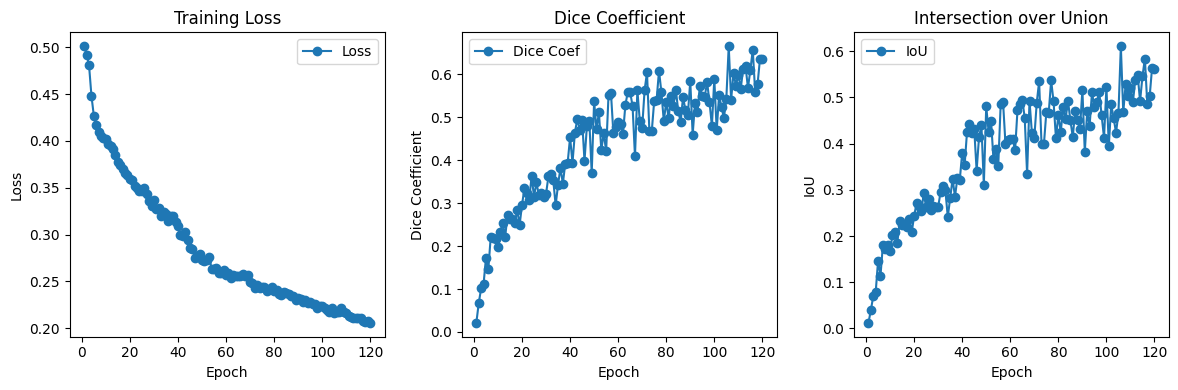

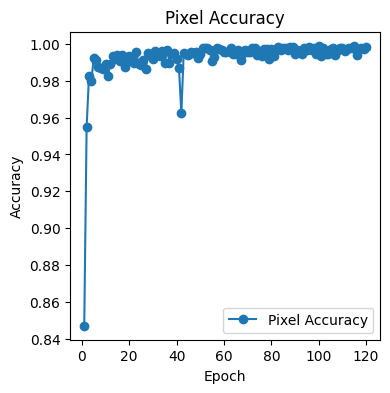

Evaluating: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


Final Evaluation Metrics:
Dice Coefficient: 0.6059
IoU Score: 0.5326
Pixel Accuracy: 0.9973


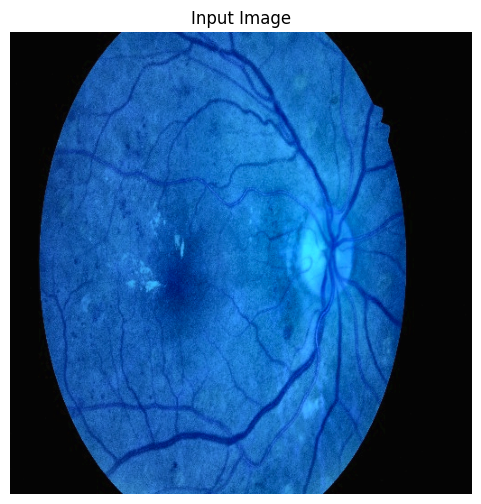

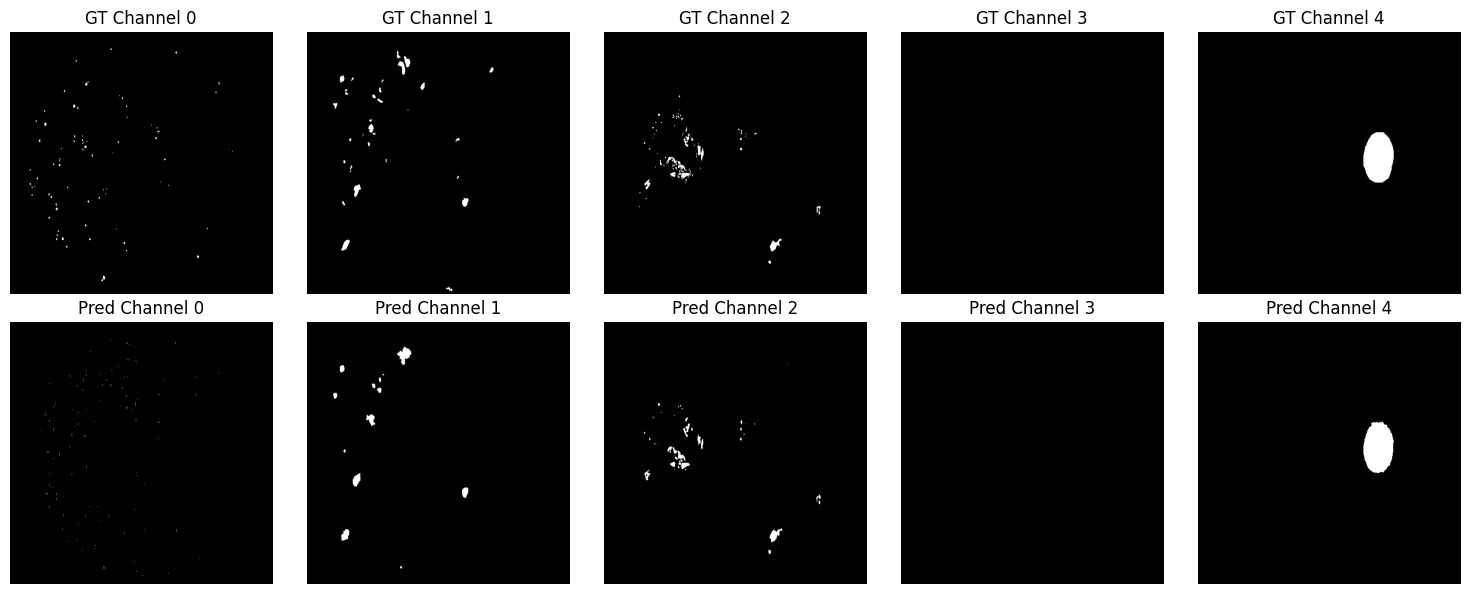

In [10]:


if __name__ == "__main__":
    # Set device to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Create dataset and dataloader
    dataset = IDRiDDataset(image_dir=OUTPUT_IMAGE_DIR, mask_dir=OUTPUT_MASK_DIR)
    train_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)
    
    # Initialize model and optimizer
    model = UNetImproved(in_channels=3, out_channels=5, drop_prob=0.1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    # Training loop
    num_epochs = 120
    print("Starting training...")
    losses, dice_scores, iou_scores, accuracies = train_model(model, train_loader, optimizer, device, num_epochs=num_epochs)
    
    # Plot training curves
    epochs = list(range(1, num_epochs+1))
    plot_training_curves(epochs, losses, dice_scores, iou_scores, accuracies)
    
    # Evaluate on the entire training set (or separate validation set if available)
    final_dice, final_iou, final_acc = evaluate_model(model, train_loader, device)
    print("\nFinal Evaluation Metrics:")
    print(f"Dice Coefficient: {final_dice:.4f}")
    print(f"IoU Score: {final_iou:.4f}")
    print(f"Pixel Accuracy: {final_acc:.4f}")
    
    # Visualize predictions on a sample image from the dataset
    visualize_predictions(model, train_loader, device)
    
    # Save the model checkpoint
    torch.save(model.state_dict(), "unet_improved_checkpoint.pth")